In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
from qiskit import assemble,execute
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [3]:
alpha_bits = 2
memory_bits = 4
aux_bits = 1
output_bits = 4
qc = QuantumCircuit(alpha_bits + memory_bits + aux_bits, output_bits)

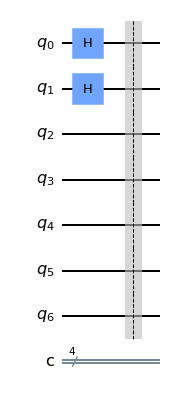

In [4]:
# address combinations
qc.h([0,1])
qc.barrier()
qc.draw()

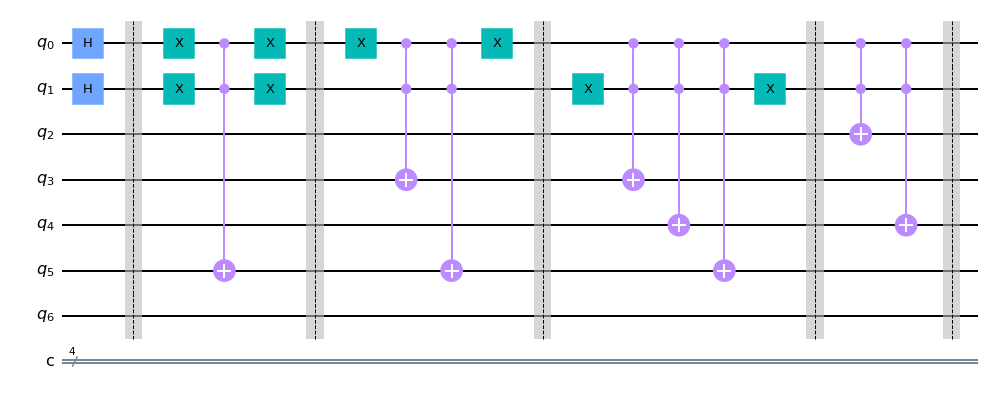

In [5]:
#Hardcoding input = [1,5,7,10] into QRAM

#[00] -> 1
qc.x([0,1])
qc.ccx(0,1,5)
qc.x([0,1])
qc.barrier()

#[01] -> 5
qc.x(0)
qc.ccx(0,1,3)
qc.ccx(0,1,5)
qc.x(0)
qc.barrier()


#[10] -> 7
qc.x(1)
qc.ccx(0,1,3)
qc.ccx(0,1,4)
qc.ccx(0,1,5)
qc.x(1)
qc.barrier()


#[11] -> 10
qc.ccx(0,1,2)
qc.ccx(0,1,4)
qc.barrier()


qc.draw()

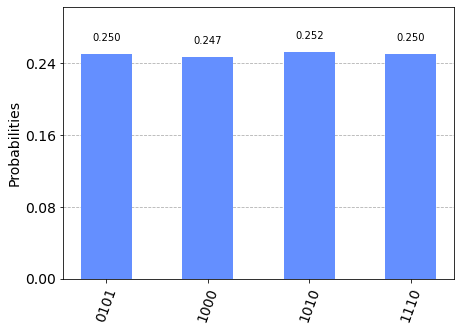

In [6]:
#qRAM status check
qc.measure([2,3,4,5],[0,1,2,3])

# Reverse the output string.
# qc = qc.reverse_bits()

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=10000, seed='12345')
result = job.result()
count =result.get_counts()
# print(count)
plot_histogram(count)

In [7]:
qRAM_qc = QuantumCircuit(6)

#[00] -> 1
qRAM_qc.x([0,1])
qRAM_qc.ccx(0,1,5)
qRAM_qc.x([0,1])

#[01] -> 5
qRAM_qc.x(0)
qRAM_qc.ccx(0,1,3)
qRAM_qc.ccx(0,1,5)
qRAM_qc.x(0)


#[10] -> 7
qRAM_qc.x(1)
qRAM_qc.ccx(0,1,3)
qRAM_qc.ccx(0,1,4)
qRAM_qc.ccx(0,1,5)
qRAM_qc.x(1)


#[11] -> 10
qRAM_qc.ccx(0,1,2)
qRAM_qc.ccx(0,1,4)


#Convert to gate
qRAM_gate = qRAM_qc.to_gate()
qRAM_gate.name = 'qRAM'

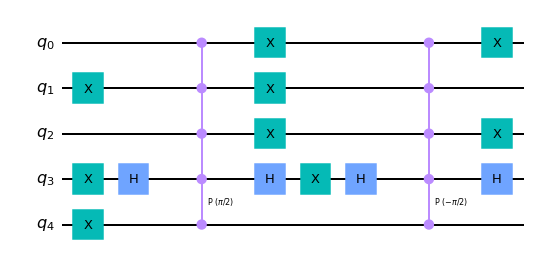

In [18]:

oracle_qc = QuantumCircuit(5)
oracle_qc.x(4)
oracle_qc.x(1)
oracle_qc.x(3)
nqubits = 5
oracle_qc.h(nqubits-2)
oracle_qc.mcp(np.pi/2,list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
oracle_qc.h(nqubits-2)
oracle_qc.x(1)
oracle_qc.x(3)
oracle_qc.x(0)
oracle_qc.x(2)

oracle_qc.h(nqubits-2)
oracle_qc.mcp(-1*np.pi/2,list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
oracle_qc.h(nqubits-2)
oracle_qc.x(0)
oracle_qc.x(2)
oracle_4 = oracle_qc.to_gate()
oracle_4.name = "U$_\omega$"
oracle_qc.draw()

In [23]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

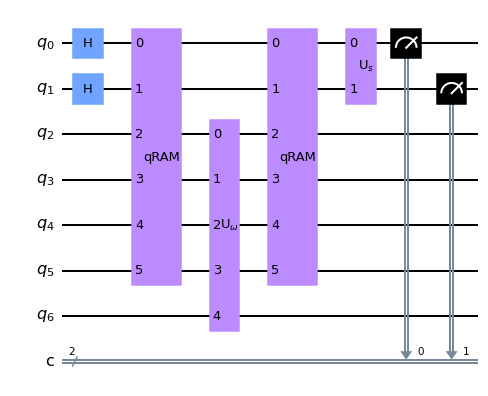

In [27]:
final_qc = QuantumCircuit(7,2)

#initialize the address qubits into a superposition
final_qc.h([0,1])

#
final_qc.append(qRAM_gate,[0,1,2,3,4,5])
final_qc.append(oracle_4,[2,3,4,5,6])
final_qc.append(qRAM_gate,[0,1,2,3,4,5])
final_qc.append(diffuser(2), [0,1])


final_qc.measure([0,1],[0,1])
# final_qc = final_qc.reverse_bits()

final_qc.draw()

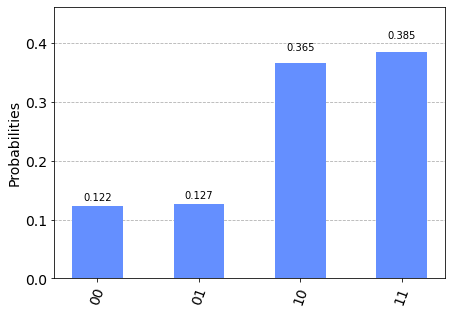

In [28]:
#Run the circuit on the simulator

backend = Aer.get_backend('qasm_simulator')
job = execute(final_qc, backend=backend, shots=10000, seed='12345')
result = job.result()
counts =result.get_counts()
# print(counts)
plot_histogram(counts)